In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.constraints import Constraint
from numpy.random import randn, randint
from keras.datasets.mnist import load_data
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
#from google.colab import drive
import matplotlib.image as mpimg

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
train_images = X_train.reshape(-1, 28, 28, 1)

In [4]:
train_images = (train_images - 127.5) / 127.5

In [5]:
selected = y_train == 3
train_ds = train_images[selected]

In [6]:
print(selected)

[False False False ... False False False]


In [6]:
len(train_ds)

6131

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices(train_ds).batch(64)

In [8]:
train_ds

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>

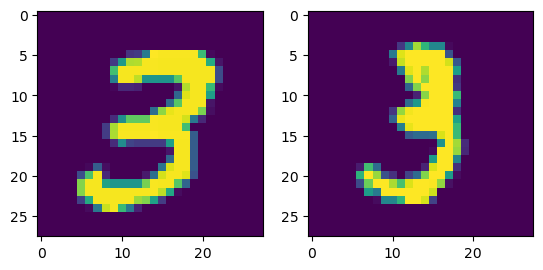

In [10]:
for image in train_ds.take(1):
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(image[i, :, :, 0].numpy())

In [11]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value
 
    # clip model weights to hypercube
    def __call__(self, weights):
        return K.clip(weights, -self.clip_value, self.clip_value)

In [12]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)
 
# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # weight constraint
    const = ClipConstraint(0.01)
    # define model
    model = Sequential()
    # downsample to 14x14
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
    model.add(BatchNormalization()) #kernel_constraint=const
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 7x7
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
    model.add(BatchNormalization()) #kernel_constraint=const
    model.add(LeakyReLU(alpha=0.2))
    # scoring, linear activation
    model.add(Flatten())
    model.add(Dense(1)) #kernel_constraint=const
    return model
 
# define the standalone generator model
def define_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # output 28x28x1
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
    return model

In [13]:
generator = define_generator(100)
critic = define_critic()

C:\Users\SHOCKER\anaconda\envs\tf_gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


tf.Tensor(
[[[[ 1.99614037e-02]
   [-1.67617518e-02]
   [ 2.05257330e-02]
   [ 1.40612824e-02]
   [ 4.12944192e-03]
   [-3.66635807e-02]
   [-3.94388102e-03]
   [-1.19962543e-02]
   [-1.02676246e-02]
   [-2.34574135e-02]
   [ 4.83202282e-03]
   [-1.71927139e-02]
   [-2.08491422e-02]
   [-2.47692801e-02]
   [ 2.44236439e-02]
   [-1.59517452e-02]
   [-1.36384685e-02]
   [-2.26599667e-02]
   [ 2.03835797e-02]
   [-1.14663374e-02]
   [ 7.89531600e-03]
   [-2.47639213e-02]
   [ 3.20951454e-04]
   [-2.81579606e-02]
   [ 1.01278108e-02]
   [-1.82914473e-02]
   [-2.02510133e-03]
   [-4.18597506e-03]]

  [[-3.09438584e-03]
   [-1.66567191e-02]
   [ 4.91390703e-03]
   [-1.83234233e-02]
   [-6.10676361e-03]
   [-5.84213994e-05]
   [-1.31535223e-02]
   [-2.44900305e-02]
   [-1.48689644e-02]
   [ 1.34690423e-02]
   [-1.74917802e-02]
   [ 2.68661696e-02]
   [-2.47163251e-02]
   [ 1.87841859e-02]
   [ 4.99158911e-03]
   [-1.31725306e-02]
   [-1.91145092e-02]
   [-1.06814029e-02]
   [ 1.42571870e-02]


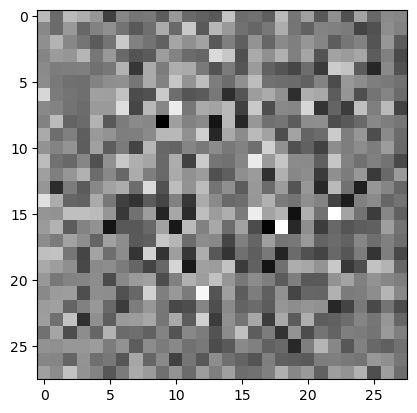

In [14]:
def generate_fake(n_samples, n_classes, latent_dim):
    labels = np.random.randint(0, n_classes, n_samples)
    noise = tf.random.normal([n_samples, latent_dim])
    return noise, labels

noise, labels = generate_fake(1, 10, 100)

gen_img = generator(noise)
print(gen_img)

plt.imshow(gen_img[0,:,:,0], cmap='gray')

In [15]:
class GAN(keras.Model):
    def __init__(self, critic, generator):
        super(GAN, self).__init__()
        self.critic = critic
        self.generator = generator
        

    def compile(self, c_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def critic_loss(self, real, fake):
        real_loss = self.loss_fn(-(tf.ones_like(real)), real)
        fake_loss = self.loss_fn(tf.ones_like(fake), fake)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake):
        fake_loss = self.loss_fn(-(tf.ones_like(fake)), fake)
        return fake_loss

    def train_step(self, batch, n_critic=5):
        #tr_image, tr_label = batch
        noise, labels = generate_fake(64, 10, 100)
        with tf.GradientTape() as gen_tape, tf.GradientTape(persistent=True) as cr_tape:
            # update the critic more.
            for i in range(n_critic):
                generated = self.generator(noise, training=True)
                loss1 = self.critic(batch[0:32, :, :, :], training=True)
                loss2 = self.critic(generated[0:32, :, :, :], training=True)
                full_loss = self.critic_loss(loss1, loss2)

                gr = cr_tape.gradient(full_loss, self.critic.trainable_variables)
                self.c_optimizer.apply_gradients(zip(gr, self.critic.trainable_variables))
                
            generated_image = self.generator(noise, training=True)

            real = self.critic(batch, training=True)
            fake = self.critic(generated_image, training=True)

            gen_loss = self.generator_loss(fake)
            cr_loss = self.critic_loss(real, fake)

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        cr_grad = cr_tape.gradient(cr_loss, self.critic.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        self.c_optimizer.apply_gradients(zip(cr_grad, self.critic.trainable_variables))
        return {"cr_loss": cr_loss, "g_loss": gen_loss}

In [16]:
WGAN = GAN(critic=critic, generator=generator)

In [17]:
WGAN.compile(c_optimizer=RMSprop(learning_rate=0.00005),
             g_optimizer=RMSprop(learning_rate=0.00005),
             loss_fn=wasserstein_loss)

In [18]:
epochs = 50
seed = tf.random.normal([16, 100])
#labels = np.random.randint(0, 10, 16)

In [19]:
#path = '/content/drive/My Drive/colab_notebooks/wgan_images/'

class Generate(keras.callbacks.Callback):
    def __init__(self):
        super(Generate, self).__init__()
        
    def on_epoch_end(self, epoch, logs=None):
        prediction = generator(seed)

        plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(prediction[i, :, :, 0], cmap='gray')
            plt.axis('off')
            
        plt.savefig(f'image at epoch {epoch+1}.png')
        plt.show

Epoch 1/50
96/96 [==============================] - 470s 5s/step - cr_loss: -30.9854 - g_loss: 4.7741
Epoch 2/50
36/96 [==========>...................] - ETA: 5:00 - cr_loss: -42.6515 - g_loss: 6.4471

KeyboardInterrupt: 

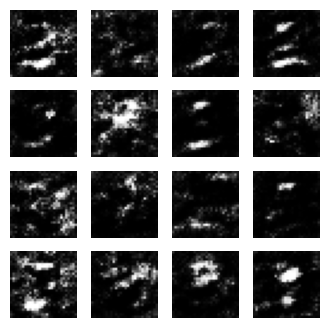

In [20]:
WGAN.fit(train_ds, epochs=50, callbacks=[Generate()])

In [ ]:
Generate().on_epoch_end(0)